# Illustration of the principle of IPW and regression-based approaches

In this notebook we simulate data and provide illustrative examples of how estimators for causal inference work.

In [1]:
%%capture

!pip install seaborn==0.11

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from scipy.special import expit
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")


sns.set_context('talk')

untreated_col = '#fc4488'
treated_col = '#2c8f80'


we simulate data (small dataset so that we can visualize the individual points). The model for the treatment is linear (logistic), and the model for the outcome is more complex. A regression-based estimator with a linear model would not be consistent here.

In [3]:
n = 2000
dim_x_observed = 1
rg = default_rng(24)
x = rg.standard_normal(n * dim_x_observed)\
                   .reshape((n, dim_x_observed))
alphas = np.zeros(dim_x_observed)
alphas[:dim_x_observed] = 1 / dim_x_observed
p_t = expit(alphas.dot(x.T))
t = rg.binomial(1, p_t, n).reshape(-1, 1)
def y_func(x, t):
    n = len(t)
    return np.sin(2*x) + 0.6*t + 0.3*x**3*t
y = y_func(x, t) + 0.4*rg.standard_normal((n, 1))


A useful check here is to look at the support of treated and untreated units to check the positivity assumption. Here we see that the assumption might not be fully true at the left of the histogram (small values of x). A solution can be to identify only the CATE for some values of X.

<Axes: ylabel='Density'>

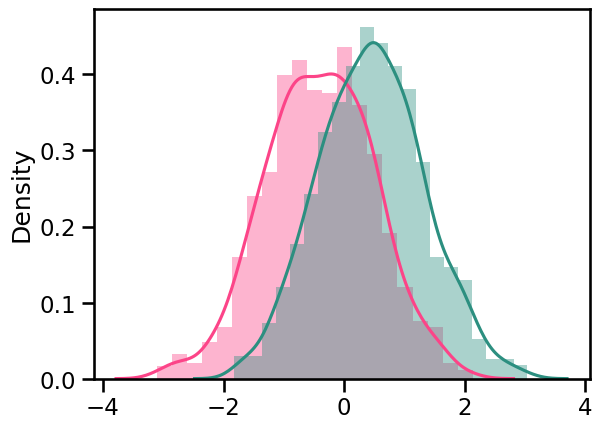

In [4]:
ax = sns.distplot(x[(t==0)], color=untreated_col)
sns.distplot(x[(t==1)], color=treated_col, ax=ax)

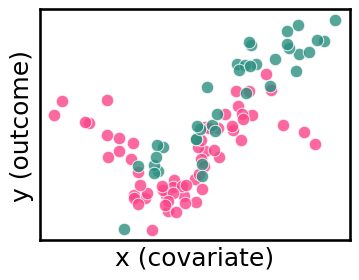

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(4,3))

sns.scatterplot(x[:100][t[:100]==0], y[:100][t[:100]==0], ax=ax, marker="o", alpha=0.8, color=untreated_col, legend=False)
sns.scatterplot(x[:100][t[:100]==1], y[:100][t[:100]==1], ax=ax, marker="o", alpha=0.8, color=treated_col, legend=False)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

ax.set_ylabel('y (outcome)')
ax.set_xlabel('x (covariate)')
plt.savefig('ipw_principle_left.pdf', bbox_inches='tight')

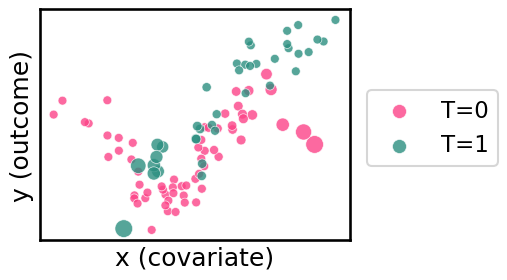

In [6]:
fig, ax = plt.subplots(ncols=1, figsize=(4,3))

sns.scatterplot(x[:100][t[:100]==0], y[:100][t[:100]==0], ax=ax, marker="o", alpha=0.8, color=untreated_col, size=p_t[:100][t[:100].ravel()==0]**8, label='T=0', legend=False)
sns.scatterplot(x[:100][t[:100]==1], y[:100][t[:100]==1], ax=ax, marker="o", alpha=0.8, color=treated_col, size=(1-p_t[:100][t[:100].ravel()==1])**8, label='T=1', legend=False)

ax.legend(bbox_to_anchor=(1.02, 0.7))

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

#ax.get_yaxis().set_visible(False)

ax.set_ylabel('y (outcome)')
ax.set_xlabel('x (covariate)')
plt.savefig('ipw_principle_right.pdf', bbox_inches='tight')

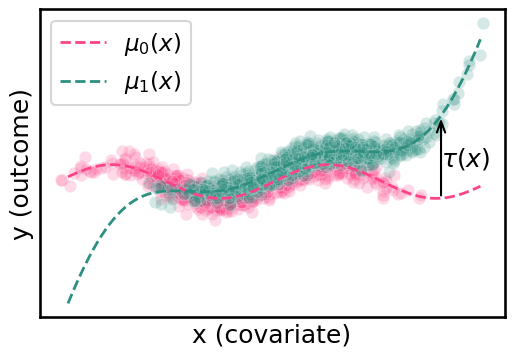

In [7]:
fig, ax = plt.subplots(figsize=(6,4))

sns.scatterplot(x[t==0], y[t==0], ax=ax, marker="o", alpha=0.2, color=untreated_col)
sns.scatterplot(x[t==1], y[t==1], ax=ax, marker="o", alpha=0.2, color=treated_col)
reg_x = np.linspace(-3, 3, 200).reshape((200, dim_x_observed))
ax.plot(reg_x, y_func(reg_x, np.zeros(200).reshape(-1, 1)), ls='--', lw=2, color=untreated_col, label=u'$\mu_0(x)$')
ax.plot(reg_x, y_func(reg_x, np.ones(200).reshape(-1, 1)), ls='--', lw=2, color=treated_col, label=u'$\mu_1(x)$')

ax.set_ylabel('y (outcome)')
ax.set_xlabel('x (covariate)')

ax.legend()

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

xx = np.array(reg_x[180])

arr = mpatches.FancyArrowPatch((xx[0], y_func(xx, np.array([0]))[0]), (xx[0], y_func(xx, np.array([1]))[0]),
                               arrowstyle='->,head_width=.15', mutation_scale=20)
ax.add_patch(arr)
ax.annotate(r'$\tau(x)$', (.5, .5), xycoords=arr, ha='left', va='center')

plt.savefig('hte_principle.pdf', bbox_inches='tight')